In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Charge X and y data that are in .npy format
X = np.load('../save_model/X.npy')
y = np.load('../save_model/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [4]:
def augment_sequence(x, noise_std=0.01, max_shift=5, scale_range=(0.9, 1.1), window_size=10):
    """
    Aplica aumento de datos a una secuencia individual de forma (300, 30)
    """
    # 1. Agregar ruido gaussiano
    noise = np.random.normal(0, noise_std, x.shape)
    x_aug = x + noise

    # 2. Desplazamiento temporal (shift)
    shift = np.random.randint(-max_shift, max_shift + 1)
    x_aug = np.roll(x_aug, shift, axis=0)

    # 3. Escalado
    scale = np.random.uniform(scale_range[0], scale_range[1])
    x_aug = x_aug * scale

    # 4. Permutación de subventanas
    num_segments = x.shape[0] // window_size
    segments = np.array_split(x_aug[:num_segments * window_size], num_segments, axis=0)
    np.random.shuffle(segments)
    x_aug = np.concatenate(segments, axis=0)

    return x_aug


def augment_dataset(X, y, augment_factor=2):
    """
    Aumenta el dataset X, y multiplicando los datos por augment_factor
    """
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        for _ in range(augment_factor):
            x_new = augment_sequence(X[i])
            X_aug.append(x_new)
            y_aug.append(y[i])

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    
    # Mezclamos con los originales si quieres:
    X_combined = np.concatenate([X, X_aug], axis=0)
    y_combined = np.concatenate([y, y_aug], axis=0)

    return X_combined, y_combined


In [5]:
X_augmented, y_augmented = augment_dataset(X, y, augment_factor=2)
print(X_augmented.shape)  # Debería ser (241 * 3, 300, 30)
print(y_augmented.shape)

(723, 300, 30)
(723,)


In [6]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((462, 300, 30), (116, 300, 30), (145, 300, 30), (462,), (116,), (145,))

In [8]:
from sklearn.utils import class_weight

# Calcular pesos automáticamente
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam

# Parámetros
n_components = 30  # número de componentes disponibles
n_models = 1      # número de modelos en el ensemble
components_per_model = 30  # cuantos componentes (features) por modelo

models = []
selected_components = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Opción: Preprocesamiento con Conv1D (opcional)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Dropout(0.3)(x)

    # Transformer Encoder
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model


# Entrenamiento de ensemble
for i in range(n_models):
    print(f"Entrenando modelo {i+1}/{n_models}")
    
    # Elegimos aleatoriamente componentes
    components_idx = np.random.choice(n_components, components_per_model, replace=False)
    selected_components.append(components_idx)
    
    # Seleccionamos esos componentes
    X_train_selected = X_train[:, :, components_idx]  # (samples, 300, components_per_model)
    X_val_selected = X_val[:, :, components_idx]

    # Creamos y entrenamos el modelo
    model = build_transformer_model((X_train_selected.shape[1], X_train_selected.shape[2]))
    
    history = model.fit(
        X_train_selected,
        y_train,
        class_weight=class_weights,
        epochs=500,
        batch_size=32,
        validation_data=(X_val_selected, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    models.append(model)
    histories.append(history)

Entrenando modelo 1/1
Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.2836 - loss: 1.4268 - val_accuracy: 0.3190 - val_loss: 1.3353 - learning_rate: 1.0000e-04
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.2965 - loss: 1.3969 - val_accuracy: 0.3879 - val_loss: 1.3232 - learning_rate: 1.0000e-04
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.3069 - loss: 1.3756 - val_accuracy: 0.3793 - val_loss: 1.3177 - learning_rate: 1.0000e-04
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.2940 - loss: 1.3553 - val_accuracy: 0.3621 - val_loss: 1.3159 - learning_rate: 1.0000e-04
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.3169 - loss: 1.3852 - val_accuracy: 0.3707 - val_loss: 1.3130 - learning_rate: 1.0000e-04
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.3342 - loss: 1.3521 - val_accuracy: 0.3621 - val_loss: 1.3110 - learning_rate: 1.0000e-04
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━

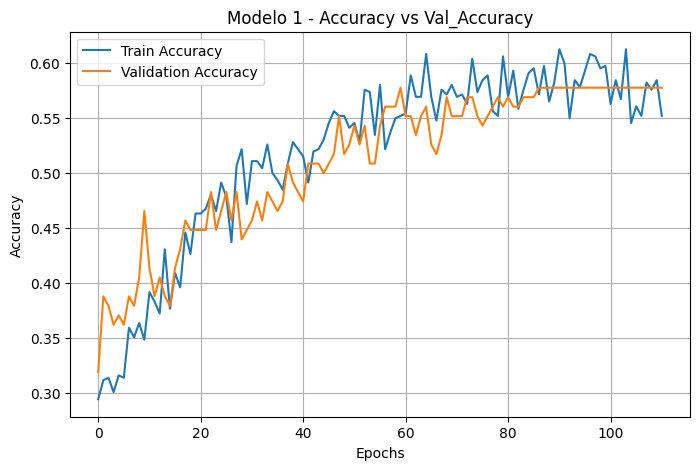

In [10]:
# Graficar accuracy de cada modelo
for i, history in enumerate(histories):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Modelo {i+1} - Accuracy vs Val_Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# Predicciones individuales de cada modelo
all_model_preds = []

for idx, model in enumerate(models):
    components_idx = selected_components[idx]
    X_test_selected = X_test[:, :, components_idx]
    
    preds = model.predict(X_test_selected)
    all_model_preds.append(preds)

# Stack de predicciones
all_model_preds = np.stack(all_model_preds, axis=0)  # (n_models, n_samples, 4)

# Promedio (soft voting)
avg_preds = np.mean(all_model_preds, axis=0)  # (n_samples, 4)

# Predicción final: clase con mayor probabilidad
final_preds = np.argmax(avg_preds, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


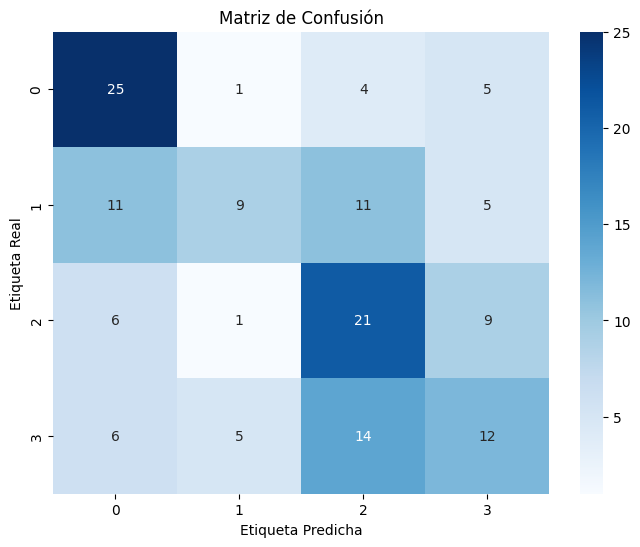

In [12]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [13]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.521     0.714     0.602        35
           1      0.562     0.250     0.346        36
           2      0.420     0.568     0.483        37
           3      0.387     0.324     0.353        37

    accuracy                          0.462       145
   macro avg      0.473     0.464     0.446       145
weighted avg      0.471     0.462     0.445       145

